### Additional analysis (2): Bayesian analysis

Based on the dataset, we can define a **Bayesian logistic regression model** that uses the **IgA-related variables** to estimate the probability of an individual being classified as **insecurely attached**. This approach is conceptually aligned with your previous findings and avoids potential confounds from hormonal measures like cortisol.


### **Bayesian Model Specification**

Let $y_i \in \{0, 1\}$ be the binary attachment label for individual $i$, where 1 = insecure, and 0 = secure.

We model the probability $p_i$ of insecure attachment via a logistic function:

$$
y_i \sim \text{Bernoulli}(p_i)
$$

$$
\text{logit}(p_i) = \alpha + \beta_1 \cdot \text{IgA}_{\text{morning}, i} + \beta_2 \cdot \text{IgA}_{\text{afternoon}, i} + \beta_3 \cdot \text{IgA}_{\text{difference}, i}
$$

Where:

* $\alpha \sim \mathcal{N}(0, 2)$ is the intercept,
* $\beta_j \sim \mathcal{N}(0, 2)$ are priors for the IgA coefficients.

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import pymc as pm
import arviz as az

In [2]:
df_data = pd.read_csv("../results_process/results_analysis_IgA_log_data.csv")
df_data.head(5)

,ID,Gender,age_baby_1,age_baby_2,age_baby_5,sIgA_Average_Morning,sIgA_Average_Afternoon,sIgA_Average_Difference,sIgA_Average_Morning_log,sIgA_Average_Afternoon_log,sIgA_Average_Difference_log,Attachment
0,1,Male,5,7.0,15.0,21.765240,28.368055,6.602815,3.077296,3.338237,0.260941,Insecure
1,4,Male,10,10.0,16.0,28.473065,50.881961,22.408896,3.348951,3.687484,0.338533,Secure
2,5,Female,5,NaN,14.0,161.424693,46.867951,-114.556742,5.084039,3.847334,-1.236705,Secure
3,7,Female,12,12.0,18.0,24.173487,35.942378,14.343241,3.179553,3.581917,0.402364,Insecure
4,11,Male,8,9.0,NaN,78.013279,382.715268,345.590046,4.196295,5.947291,1.750996,Insecure


In [3]:
# Encode attachment
df_data['Attachment_binary'] = df_data['Attachment'].map({'Secure': 0, 'Insecure': 1})

# Select predictors
X = df_data[['sIgA_Average_Morning_log', 'sIgA_Average_Afternoon_log', 'sIgA_Average_Difference_log']]
y = df_data['Attachment_binary'].values

# Normalize predictors
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
iga_morning = X_scaled[:, 0]
iga_afternoon = X_scaled[:, 1]
iga_diff = X_scaled[:, 2]

# Define Bayesian logistic regression model
with pm.Model() as iga_model:
    alpha = pm.Normal("alpha", mu=0, sigma=2)
    beta_morning = pm.Normal("beta_siga_morning", mu=0, sigma=2)
    beta_afternoon = pm.Normal("beta_siga_afternoon", mu=0, sigma=2)
    beta_diff = pm.Normal("beta_siga_diff", mu=0, sigma=2)

    # Linear predictor
    mu = (alpha +
          beta_morning * iga_morning +
          beta_afternoon * iga_afternoon +
          beta_diff * iga_diff)

    theta = pm.Deterministic("theta", pm.math.sigmoid(mu))
    y_obs = pm.Bernoulli("y_obs", p=theta, observed=y)

    # Posterior sampling
    trace = pm.sample(
        draws=1000,
        tune=1000,
        chains=2,
        cores=1,
        init="adapt_diag",
        target_accept=0.9,
        return_inferencedata=True
    )

# Posterior summary
az.summary(trace, hdi_prob=0.94)

Initializing NUTS using adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [alpha, beta_siga_morning, beta_siga_afternoon, beta_siga_diff]


/home/david/miniconda3/envs/training_models_pi/lib/python3.12/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 3 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.725,0.459,-1.680,0.083,0.015,0.013,892.0,968.0,1.00
beta_siga_morning,-1.093,1.167,-3.213,1.014,0.044,0.027,691.0,877.0,1.01
beta_siga_afternoon,0.041,1.203,-2.195,2.242,0.047,0.029,669.0,626.0,1.01
beta_siga_diff,1.024,1.274,-1.468,3.227,0.049,0.031,687.0,886.0,1.01
theta[0],0.559,0.114,0.353,0.771,0.003,0.002,1881.0,1576.0,1.00
theta[1],0.470,0.103,0.292,0.672,0.003,0.002,1141.0,1165.0,1.00
theta[2],0.014,0.034,0.000,0.056,0.001,0.003,1216.0,1242.0,1.00
theta[3],0.569,0.108,0.375,0.770,0.003,0.002,1558.0,1213.0,1.00
theta[4],0.598,0.281,0.125,0.999,0.006,0.004,1869.0,1641.0,1.00
theta[5],0.415,0.097,0.243,0.606,0.003,0.002,1006.0,1101.0,1.00


In [4]:
summary = az.summary(
    trace,
    var_names=["beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff"],
    hdi_prob=0.95,
    stat_focus="mean",
    round_to=None
)
summary["var_names"] = summary.index

In [5]:
summary

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat,var_names
beta_siga_morning,-1.093,1.167,-3.401,1.021,0.044,0.027,691.0,877.0,1.01,beta_siga_morning
beta_siga_afternoon,0.041,1.203,-2.303,2.310,0.047,0.029,669.0,626.0,1.01,beta_siga_afternoon
beta_siga_diff,1.024,1.274,-1.468,3.440,0.049,0.031,687.0,886.0,1.01,beta_siga_diff


In [8]:
from joblib import dump
dump(trace, "../generated_models/inference_models_without_cortisol.joblib")

['../generated_models/inference_models_without_cortisol.joblib']

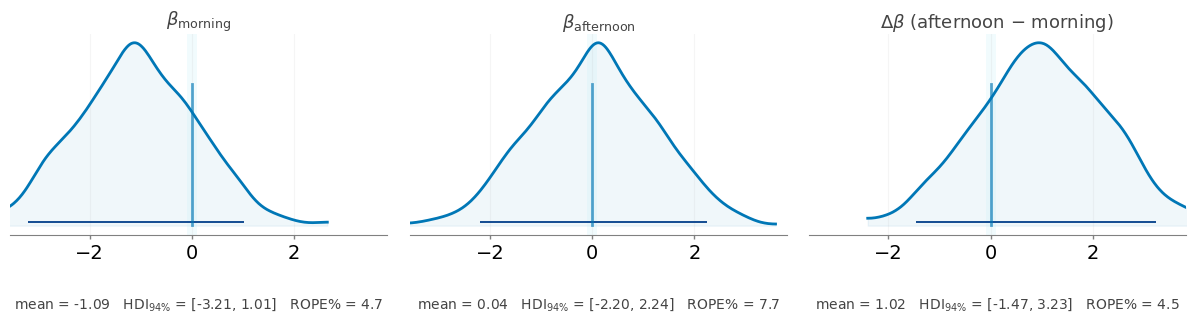

In [10]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np

FEDERAL_BLUE  = "#023E8A"   
MARIAN_BLUE   = "#0077B6"   
ROPE_FILL     = "#CAF0F8"   
HDI_BAR_COLOR = "#333333"   
TEXT_GRAY     = "#444444"   

vars_plot = ["beta_siga_morning", "beta_siga_afternoon", "beta_siga_diff"]
nice_labels = {
    "beta_siga_morning": r"$\beta_{\mathrm{morning}}$",
    "beta_siga_afternoon": r"$\beta_{\mathrm{afternoon}}$",
    "beta_siga_diff": r"$\Delta\beta$ (afternoon − morning)",
}
hdi = 0.94
rope = (-0.10, 0.10)

idata = trace

ds = az.extract(idata, var_names=vars_plot, combined=True)
all_vals = np.concatenate([ds[v].values for v in vars_plot])
xmin = float(np.percentile(all_vals, 0.5))
xmax = float(np.percentile(all_vals, 99.5))

fig, axes = plt.subplots(1, 3, figsize=(12, 3.1), constrained_layout=True)

for ax, v in zip(axes, vars_plot):
    az.plot_posterior(
        idata, var_names=[v], ax=ax, kind="kde",
        point_estimate="mean", hdi_prob=hdi, ref_val=0.0
    )

    for t in list(ax.texts):
        t.remove()

    for ln in ax.lines:
        if np.isfinite(ln.get_ydata()).any():      
            ln.set_color(MARIAN_BLUE); ln.set_linewidth(2.0)
    if len(ax.lines) >= 2:
        ax.lines[-2].set_color(FEDERAL_BLUE); ax.lines[-2].set_linewidth(1.3)

    for col in ax.collections:
        col.set_facecolor(MARIAN_BLUE); col.set_edgecolor(MARIAN_BLUE); col.set_alpha(0.06)

    for l in ax.lines:
        if l.get_linewidth() > 2.5 and (l.get_ydata()==l.get_ydata()[0]).all():
            l.set_color(HDI_BAR_COLOR); l.set_linewidth(3.2)

    ax.axvspan(rope[0], rope[1], color=ROPE_FILL, alpha=0.25, lw=0)

    vals = ds[v].values
    mean = np.mean(vals)
    hdi_low, hdi_high = az.hdi(vals, hdi_prob=hdi)
    pct_in_rope = 100 * np.mean((vals >= rope[0]) & (vals <= rope[1]))
    caption = (fr"mean = {mean:.2f}   "
               fr"HDI$_{{{int(hdi*100)}\%}}$ = [{hdi_low:.2f}, {hdi_high:.2f}]   "
               fr"ROPE% = {pct_in_rope:.1f}")
    ax.text(0.5, -0.30, caption, ha="center", va="top",
            transform=ax.transAxes, color=TEXT_GRAY, fontsize=10)

    ax.set_title(nice_labels.get(v, v), fontsize=13, color=TEXT_GRAY, pad=4)
    ax.set_ylabel("")
    ax.set_xlim(xmin, xmax)
    ax.grid(True, axis="x", alpha=0.12)
    ax.spines["right"].set_visible(False); ax.spines["top"].set_visible(False)


fig.savefig("../tmp_figures/posterior_siga.pdf", bbox_inches="tight")
plt.show()
